This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd # standard naming convention
import numpy as np
   
file_name = "./data/data_000637.txt"
data = pd.read_csv(file_name)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [3]:
bx = data["BX_COUNTER"]
bx
print("Max Numbers", max(bx))

Max Numbers 3563


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [5]:
data ['NANOSECONDS']= data ['TDC_MEAS']*25/30+data['BX_COUNTER']*25+data['ORBIT_CNT']*3564*25
data ['NANOSECONDS']= data['NANOSECONDS'] - data.loc[0]['NANOSECONDS']
print ("Duration:", (data.loc[14999]['NANOSECONDS']- data.loc[0]['NANOSECONDS'])*10**(-9), "second")
data

Duration: 0.0133050033125 second


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,NANOSECONDS
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,9.804161e+08
1310716,1,1,4,3869211171,763,11,9.804161e+08
1310717,1,0,64,3869211171,764,0,9.804161e+08
1310718,1,0,139,3869211171,769,0,9.804163e+08


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [6]:
data ['NANOSECONDS']= data ['TDC_MEAS']*25/30+data['BX_COUNTER']*25+data['ORBIT_CNT']*3564*25
data ['NANOSECONDS']= data['NANOSECONDS'] - data.loc[0]['NANOSECONDS']
print ("Duration:", (data.loc[14999]['NANOSECONDS']- data.loc[0]['NANOSECONDS'])*10**(-9), "second")
data

Duration: 0.0133050033125 second


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,NANOSECONDS
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,9.804161e+08
1310716,1,1,4,3869211171,763,11,9.804161e+08
1310717,1,0,64,3869211171,764,0,9.804161e+08
1310718,1,0,139,3869211171,769,0,9.804163e+08


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [16]:
x = data.groupby(by='TDC_CHANNEL', sort=True).count()
x =x.sort_values('HEAD', ascending=False)
print("List of noisy TDC_CHANNES: ", [x for x in x.index[0:3]])

List of noisy TDC_CHANNES:  [139, 64, 63]


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [15]:
count_nonempty=0
count_tdcchannel=0

for i in range(data['ORBIT_CNT'][0], data['ORBIT_CNT'][14999]):
    if i in list(zip(*data.values.tolist()))[3]:
        count_nonempty+=1
        x = data.loc[(data['ORBIT_CNT'] == i) & (data['TDC_CHANNEL']==139)]
        if not x.empty:
            count_tdcchannel += 1
        
print ("Number of non-empty orbits: " ,count_nonempty)
print("Number of non-empty orbits with at least one measurement TDC_CHANNEL=139 " ,count_tdcchannel)


Number of non-empty orbits:  149
Number of non-empty orbits with at least one measurement TDC_CHANNEL=139  149


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

Matplotlib is building the font cache; this may take a moment.


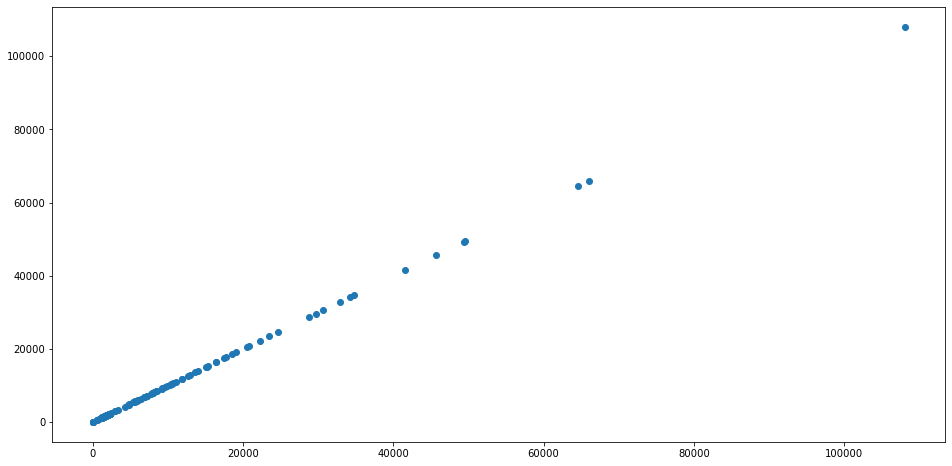

In [17]:
from matplotlib import pyplot as plt

a= data.groupby('TDC_CHANNEL').count()['FPGA']
x = [i for i in a.index]
y = [i for i in a.values]

fig = plt.figure(figsize=(16,8))
plt.scatter(y,z)